<a href="https://colab.research.google.com/github/amd257/COVID-detection-using-CNNs/blob/FinalRound/Xception_ThreeLabel_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#Getting the compressed Three Label Classification Dataset file stored at: https://www.dropbox.com/s/n17olwvllwbnyl6/threelabeldataset.zip?dl=0
!wget https://www.dropbox.com/s/n17olwvllwbnyl6/threelabeldataset.zip?dl=0

--2021-03-08 21:38:50--  https://www.dropbox.com/s/n17olwvllwbnyl6/threelabeldataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/n17olwvllwbnyl6/threelabeldataset.zip [following]
--2021-03-08 21:38:50--  https://www.dropbox.com/s/raw/n17olwvllwbnyl6/threelabeldataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca1955972605622bbc9d26a2602.dl.dropboxusercontent.com/cd/0/inline/BKWWUuUKL8GROUp5B84ss-hKoIZlXVIl3Yf0Tdd2iLamLtL1ik05tLws7XtHg_nEy7RyeiZ0Mnm2TUdOMmay-erfDkI0yWtDcdJW9Il0MdrDEWhfnwFgtGAKRR-noa22DyLRJaJBYmriZrXN-jHWbxmk/file# [following]
--2021-03-08 21:38:51--  https://uca1955972605622bbc9d26a2602.dl.dropboxusercontent.com/cd/0/inline/BKWWUuUKL8GROUp5B84ss-hKoIZlXVIl3Yf0Tdd2iLamLtL1ik05tLws7X

In [ ]:
!unzip /content/threelabeldataset.zip?dl=0   #Extracting the compressed dataset file

In [63]:
#Importing all the libraries required for preprocessing, training and evaluation of the model
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory #Importing Functions for image preprocessing from keras
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau #Importing Functions for early stopping and learning rate reduction
from sklearn.utils import class_weight #Importing functions for computing class weights from scikit learn class_weight module
from keras.utils import plot_model
from keras.preprocessing import image
from keras.layers import *
from keras.models import * #Importing the functions required for creating the model
import matplotlib.pyplot as plt #For plotting the training and validation loss and accuracy graphs
import numpy as np
import pandas as pd

In [64]:
train_images_path = "ThreeLabelDataset/Train"
validation_images_path = "ThreeLabelDataset/Validation"
test_images_path = "ThreeLabelDataset/Test"
image_height = 299 #Default input image size for Xception model
image_width = 299

In [65]:
#Training data augmentation before feeding it to the CNN model
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,  #flipping will add more variations to the data and it will help fight overfitting as welll
    )

#Preprocessing the training dataset
train_dataset= train_datagen.flow_from_directory(
    train_images_path,
    target_size = (image_height,image_width), 
    batch_size = 32,
    color_mode="grayscale",
    class_mode = "categorical",
    shuffle = True,
    seed =40
    )

inp_shape= train_dataset.image_shape
print("Input Shape: " , inp_shape)
print("Class Labels: ", train_dataset.class_indices)

Found 3108 images belonging to 3 classes.
Input Shape:  (299, 299, 1)
Class Labels:  {'COVID': 0, 'Normal': 1, 'ViralPneumonia': 2}


In [66]:
validation_datagen = image.ImageDataGenerator(rescale = 1./255) #Rescaling the validation images 

#Preprocessing the validation dataset
validation_dataset = validation_datagen.flow_from_directory(
    validation_images_path,
    target_size = (image_height,image_width),
    batch_size = 32,
    color_mode = "grayscale" ,
    class_mode = "categorical",
    shuffle = True,
    seed =40
    )

inp_shape= validation_dataset.image_shape
print("Input Shape: " , inp_shape)
print("Class Labels: ", validation_dataset.class_indices)

Found 388 images belonging to 3 classes.
Input Shape:  (299, 299, 1)
Class Labels:  {'COVID': 0, 'Normal': 1, 'ViralPneumonia': 2}


In [67]:
test_datagen = image.ImageDataGenerator(rescale = 1./255) #Rescaling the test images 

#Preprocessing the testing dataset
test_dataset = test_datagen.flow_from_directory(
    test_images_path,
    target_size = (image_height,image_width),
    batch_size = 32,
    color_mode = "grayscale" ,
    class_mode = "categorical",
    shuffle = True,
    seed =40
    )

inp_shape= test_dataset.image_shape
print("Input Shape: " , inp_shape)
print("Class Labels: ", test_dataset.class_indices)

Found 312 images belonging to 3 classes.
Input Shape:  (299, 299, 1)
Class Labels:  {'COVID': 0, 'Normal': 1, 'ViralPneumonia': 2}


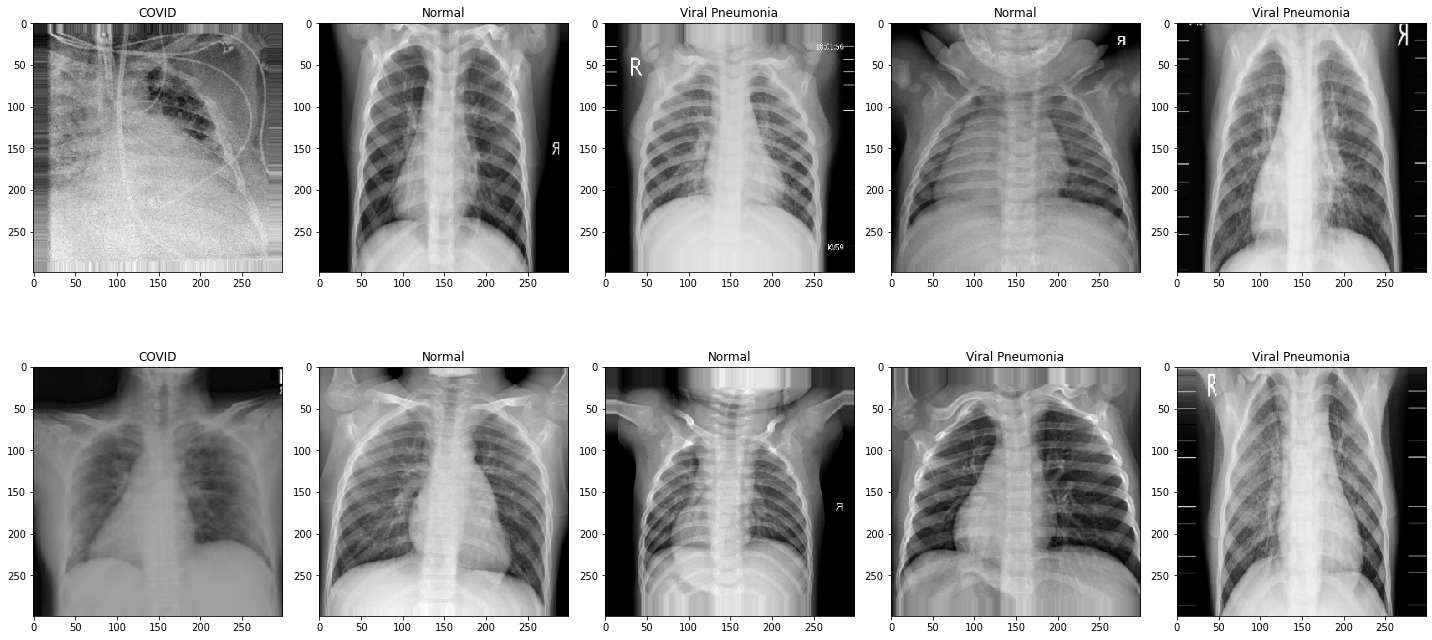

In [22]:
#Visualization of Preprocessed Data
plt.figure(figsize=(20, 10))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train_dataset:
        image = X_batch[0]        
        dic = {0: 'COVID', 1:'Normal', 2:'Viral Pneumonia'}
        img_index = np.argmax(Y_batch) #to get index of the image label 
        plt.title(label= dic.get(img_index))
        plt.axis('on')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [79]:
model = keras.applications.Xception(weights=None, input_shape=inp_shape, classes=3, classifier_activation='softmax')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #changed the optimizer from rmsprop to adam
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 288         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

(None, 299, 299, 1)


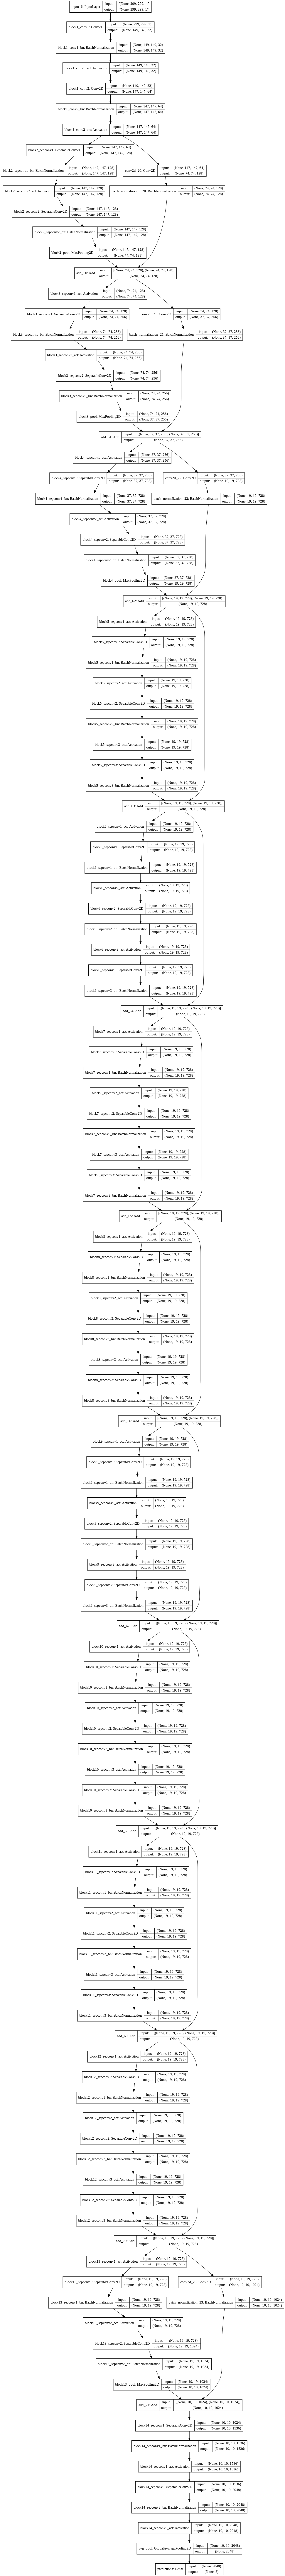

In [80]:
print(model.input.shape)
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [81]:
STEP_SIZE_TRAIN=train_dataset.n//train_dataset.batch_size
STEP_SIZE_VALID=validation_dataset.n//validation_dataset.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

97
12


In [82]:
#Defining functions for early stopping and adjusting the learning rate during model training 
earlyStop = EarlyStopping(monitor="val_loss", mode="min", patience=4, verbose= 1)
learningRateReduce = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.4, min_lr=0.0000001)
callbacksList = [ earlyStop, learningRateReduce]

In [83]:
#Assigning class weights using the compute class weights function
classWeights = class_weight.compute_class_weight('balanced', np.unique(train_dataset.classes), train_dataset.classes)
classWeightsDict = dict(enumerate(classWeights))
print("The class weights to be assigned to each label are:", classWeightsDict)

The class weights to be assigned to each label are: {0: 1.0791666666666666, 1: 0.9664179104477612, 2: 0.9628252788104089}


In [84]:
history = model.fit(
    train_dataset, 
    steps_per_epoch = STEP_SIZE_TRAIN, 
    epochs=100,
    validation_data = validation_dataset,
    validation_steps = STEP_SIZE_VALID,
    class_weight = classWeightsDict,
    callbacks=callbacksList
    )

Epoch 1/100
97/97 [==============================] - 127s 1s/step - loss: 0.6151 - accuracy: 0.7667 - val_loss: 1.1089 - val_accuracy: 0.3125
Epoch 2/100
97/97 [==============================] - 121s 1s/step - loss: 0.2564 - accuracy: 0.9117 - val_loss: 1.1881 - val_accuracy: 0.3047
Epoch 3/100
97/97 [==============================] - 120s 1s/step - loss: 0.2571 - accuracy: 0.9105 - val_loss: 1.2913 - val_accuracy: 0.3490

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 4/100
97/97 [==============================] - 120s 1s/step - loss: 0.1819 - accuracy: 0.9282 - val_loss: 2.0900 - val_accuracy: 0.3411
Epoch 5/100
97/97 [==============================] - 121s 1s/step - loss: 0.1585 - accuracy: 0.9384 - val_loss: 2.6953 - val_accuracy: 0.5417

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00016000000759959222.
Epoch 6/100
97/97 [==============================] - 121s 1s/step - loss: 0.1202 - accuracy: 0.9619 - val_loss: 2.4721 - val_ac

In [89]:
model.save('Xception_ThreeLabelFinal.h5')

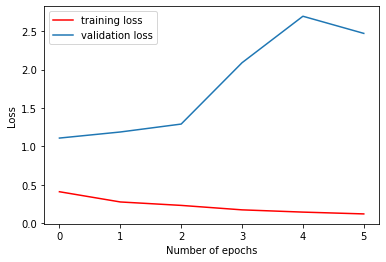

In [90]:
#Plotting the graph for training and validation loss
plt.locator_params(axis='x', integer=True, tight=True) #To ensure no. of epochs is shown as integers
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

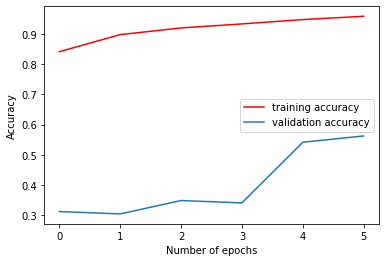

In [91]:
#Plotting the graph for training and validation accuracy
plt.locator_params(axis='x', integer=True, tight=True) #To ensure no. of epochs is shown as integers
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

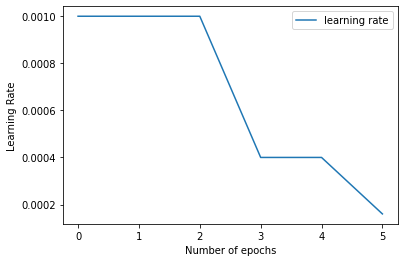

In [92]:
#Plotting the graph for learning rate
plt.locator_params(axis='x', integer=True, tight=True) #To ensure no. of epochs is shown as integers
plt.plot(history.history['lr'],label='learning rate')
plt.xlabel('Number of epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

In [93]:
testingAccuracy = model.evaluate(test_dataset) #Evaluating the model on the testing dataset
print("The Xception model has a testing accuracy of:", testingAccuracy[1]*100, "%")

10/10 [==============================] - 4s 380ms/step - loss: 2.4154 - accuracy: 0.5897
The Xception model has a testing accuracy of: 58.974361419677734 %
